# Mapping $\mathbb R^2 \rightarrow \mathbb R$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl, matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from neurodyn import *

In [22]:
rnn = LowRankCyclingRNN.new_valentin(p=2, N=20_000, phi=sigmoid, I_ext=zero, exclude_self_connections=True, delta=6, shift=1)
res = rnn.simulate(rnn.F[:, 0], (0, 60), dt_max=0.4, progress=True, cache=True)
print(rnn)

LowRankCyclingRNN{N=20000, p=2, delta=6, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=True}


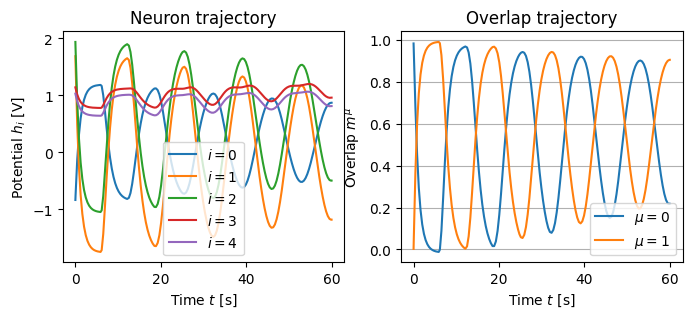

In [4]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
plot_neuron_trajectory(res, figax=(fig, axes[0]));
plot_overlap_trajectory(rnn, res, figax=(fig, axes[1]));

## 2D embedding

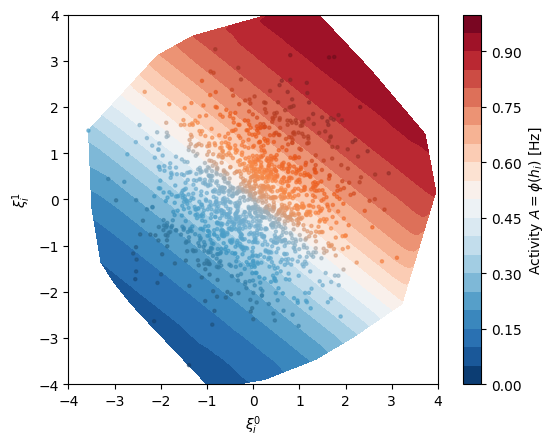

In [5]:
activity = rnn.phi(res.h[:, 3])
fig, ax = plt.subplots()
plot_2D_embedding_contour(rnn, activity, figax=(fig, ax))
plot_2D_embedding_scatter(rnn, activity, figax=(fig, ax))
ax.set_xlim((-4, 4))
ax.set_ylim((-4, 4))
plt.show()

## 1D embedding

### Cantor-type (bijection)

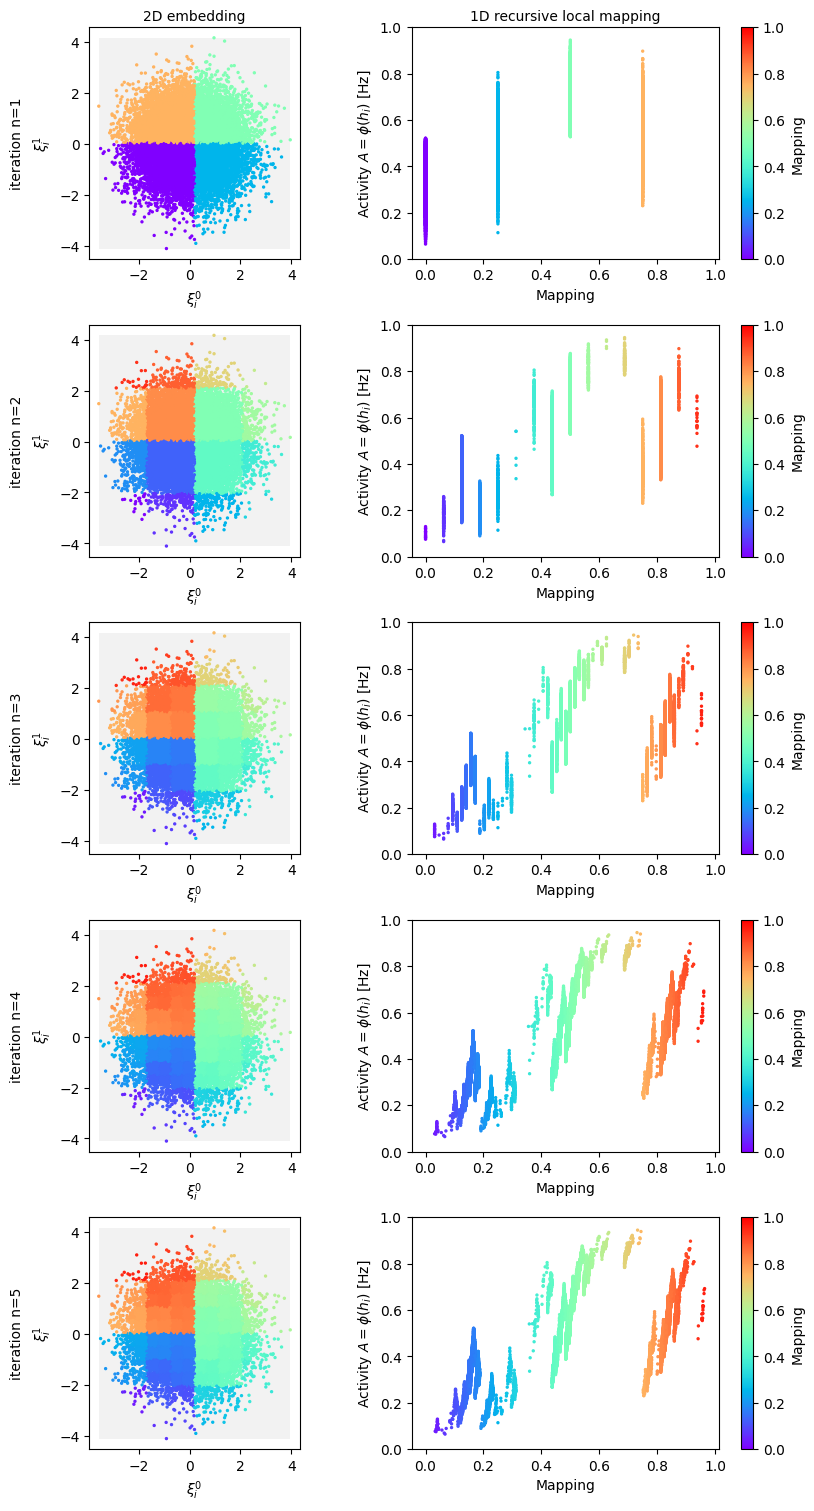

In [6]:
ns = [1, 2, 3, 4, 5]

fig, axes = plt.subplots(ncols=2, nrows=len(ns), figsize=(4*2, 3*len(ns)), constrained_layout=True, sharex='col')

for i, n in enumerate(ns):
	mapping = RecursiveLocalMapping(n)(rnn.F)
	bbox = Box(rnn.F[:, 0].min(), rnn.F[:, 0].max(), rnn.F[:, 1].min(), rnn.F[:, 1].max())
	axes[i, 0].add_patch(plt.Rectangle((bbox.xmin, bbox.ymin), bbox.xmax-bbox.xmin, bbox.ymax-bbox.ymin, fc='k', alpha=0.05))
	plot_2D_to_1D_mapping(rnn, mapping, activity, figax=(fig, axes[i, :]), cmap='rainbow', s=2, vmin=0, vmax=1)
	axes[i, 0].xaxis.set_tick_params(labelbottom=True)  # get ticks back
	axes[i, 1].xaxis.set_tick_params(labelbottom=True)  # get ticks back
	axes[i, 1].set_ylim((0, 1))

add_headers(fig, row_headers=[f'iteration {n=}' for n in ns])
add_headers(fig, col_headers=['2D embedding', '1D recursive local mapping'])

plt.show()

In [23]:
from pathlib import Path
from tqdm import tqdm
from matplotlib import animation
from math import ceil

def animate2d_vs_1d_recursive_quadrant(rnn: LowRankRNN, res: Result, outpath: Path, time_stride: int = 1, Nmax: int = 5000):
	idt = 0
	activity = rnn.phi(res.h)
	cmap = mpl.colormaps['RdBu_r']

	fig, axes = plt.subplot_mosaic([
		['a1', 'b'],
		['a2', 'b'],
		['m' , 'm'],
	], figsize=(4*2, 3*2), height_ratios=[1.8, 0.2, 1.5], layout='constrained')

	mapping = RecursiveLocalMapping(nrec=5)(rnn.F)
	scat1d = axes['a1'].scatter(mapping, activity[:, idt], c='k', alpha=0.2, s=3, ec=None)
	axes['a1'].xaxis.set_major_locator(plt.NullLocator())
	axes['a1'].xaxis.set_minor_locator(plt.NullLocator())
	axes['a1'].set_xlim((0, 1))
	axes['a1'].set_ylabel('activity')
	axes['a1'].set_title('Recursive local mapping $R^2 \\rightarrow [0,1]$')
	# 4**n is the number of bins
	# we use n=5 in reality, but show n=4 because otherwise it becomes difficult to see
	bins = stats.binned_statistic(mapping, activity[:, idt], statistic='mean', bins=4**3, range=(0,1))
	img1d = axes['a2'].imshow(bins.statistic[None, :], extent=((0,1,0,1)), cmap='RdBu_r', vmin=0, vmax=1, aspect=1/20)
	axes['a2'].yaxis.set_visible(False)
	axes['a2'].set_xlabel('recursive local mapping')

	# _, contour = plot_2D_embedding_contour(rnn, activity[:, idt], figax=(fig, axes['b']))
	contour = None
	scat2d = axes['b'].scatter(rnn.F[:Nmax, 0], rnn.F[:Nmax, 1], c=activity[:Nmax, idt], cmap='RdBu_r', s=5, edgecolor=None, vmin=0, vmax=1, zorder=1000)
	cbar = fig.colorbar(scat2d, ax=axes['b'], label='Activity $A = \\phi(h_i)$ [Hz]')
	
	axes['b'].set_xlim((-4, 4))
	axes['b'].set_ylim((-4, 4))
	axes['b'].set_aspect('equal')
	axes['b'].set_title('2D embedding')

	plot_overlap_trajectory(rnn, res, figax=(fig, axes['m']))
	line = axes['m'].axvline(res.t[idt], color='tab:gray', linestyle='--')

	things = dict(contour=contour, scat1d=scat1d, img1d=img1d, scat2d=scat2d, line=line)

	with tqdm(total=ceil(len(res.t)/time_stride)+1) as pbar:
		def update(idt: int):
			# update the contour
			if contour is not None:
				for artist in things['contour'].collections:
					artist.remove()
				things['contour'] = axes['b'].tricontourf(rnn.F[:, 0], rnn.F[:, 1], activity[:, idt], levels=np.linspace(0, 1, 20+1), cmap='RdBu_r')
			
			# update the line
			things['line'].set_xdata([res.t[idt], res.t[idt]])

			# update the 2d scatter
			# things['scat2d'].set_facecolors([ scale_lightness(c[:3], 0.7) for c in cmap(activity[:Nmax, idt]) ])
			things['scat2d'].set_array(activity[:Nmax, idt])

			# update the 1d scatter
			things['scat1d'].set_offsets(np.column_stack((mapping, activity[:, idt])))

			# update the 1d image
			bins = stats.binned_statistic(mapping, activity[:, idt], statistic='mean', bins=4**3, range=(0,1))
			things['img1d'].set_data(bins.statistic[None, :])

			pbar.update(1)

		ani = animation.FuncAnimation(fig, update, frames=range(0, len(res.t), time_stride))
		ani.save(outpath, writer='ffmpeg', fps=15)

		plt.close()


animate2d_vs_1d_recursive_quadrant(rnn, res, 'animations/mapping_recursive_quadrant.mp4')

100%|██████████| 155/155 [03:13<00:00,  1.25s/it]


### Peano-type (surjective and continuous)

#### Linear functions

obviously continuous and surjective

In [17]:
def linear_mapping(F: np.ndarray, tangent: np.ndarray) -> np.ndarray:
	return LinearMapping(tangent)(F)

def x_projection_mapping(F: np.ndarray) -> np.ndarray:
	"""Linear projection mapping R² -> R by projecting on (1, 0)"""
	tangent = np.zeros(F.shape[1])
	tangent[0] = 1
	return linear_mapping(F, tangent)

def y_projection_mapping(F: np.ndarray) -> np.ndarray:
	"""Linear projection mapping R² -> R by projecting on (0, 1)"""
	tangent = np.zeros(F.shape[1])
	tangent[1] = 1
	return linear_mapping(F, tangent)

def xy_projection_mapping(F: np.ndarray, angle: float = np.pi/4) -> np.ndarray:
	"""Linear projection mapping R² -> R by projecting on (sin(angle), cos(angle))"""
	tangent = np.zeros(F.shape[1])
	tangent[0] = np.cos(angle)
	tangent[1] = np.sin(angle)
	return linear_mapping(F, tangent)

def xy45_projection_mapping(F: np.ndarray) -> np.ndarray:
	"""Linear projection mapping R² -> R by projecting on (sin(pi/4), cos(pi/4))"""
	return xy_projection_mapping(F, angle=np.pi/4)

def xy135_projection_mapping(F: np.ndarray) -> np.ndarray:
	"""Linear projection mapping R² -> R by projecting on (sin(3pi/4), cos(3pi/4))"""
	return xy_projection_mapping(F, angle=3*np.pi/4)

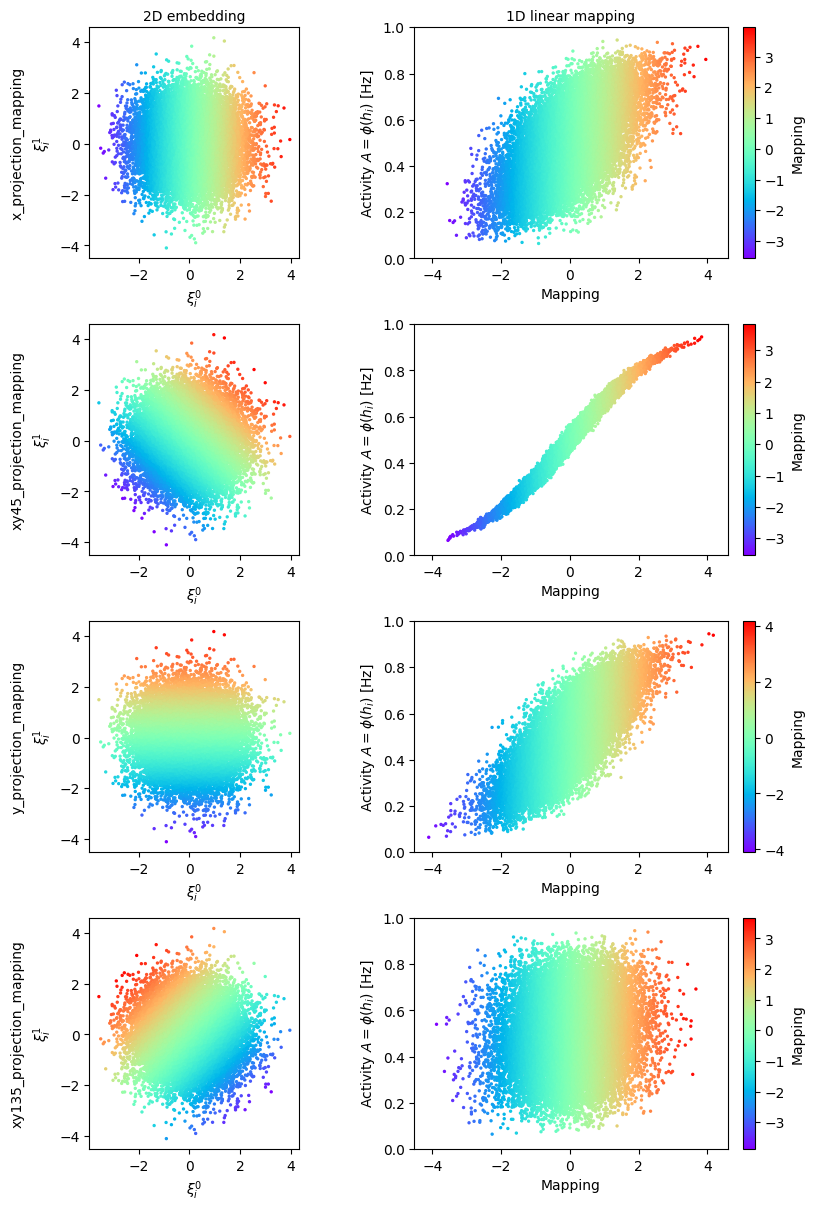

In [21]:
mapping_fns = [x_projection_mapping, xy45_projection_mapping, y_projection_mapping, xy135_projection_mapping]

fig, axes = plt.subplots(ncols=2, nrows=len(mapping_fns), figsize=(4*2, 3*len(mapping_fns)), constrained_layout=True, sharex='col')

for i, mapping_fn in enumerate(mapping_fns):
	plot_2D_to_1D_mapping(rnn, mapping_fn(rnn.F), activity, figax=(fig, axes[i, :]), cmap='rainbow', s=2);
	axes[i, 0].xaxis.set_tick_params(labelbottom=True)  # get ticks back
	axes[i, 1].xaxis.set_tick_params(labelbottom=True)  # get ticks back
	axes[i, 1].set_ylim((0, 1))

add_headers(fig, row_headers=[mapping_fn.__name__ for mapping_fn in mapping_fns])
add_headers(fig, col_headers=['2D embedding', '1D linear mapping'])

fig.savefig('../presentation/2023-04-20/mapping_linear.png', transparent=True)
plt.show()

In [20]:
from pathlib import Path
from tqdm import tqdm
from matplotlib import animation
from math import ceil

def animate2d_vs_1d_linear(rnn: LowRankRNN, res: Result, outpath: Path, time_stride: int = 1, Nmax: int = 5000):
	idt = 0
	activity = rnn.phi(res.h)
	cmap = mpl.colormaps['RdBu_r']

	fig, axes = plt.subplot_mosaic([
		['lin11', 'lin21', 'lin31', 'lin41', 'b'],
		['lin12', 'lin22', 'lin32', 'lin42', 'b'],
		['m',     'm',     'm',     'm',     'm'],
	], figsize=(4*5, 3*2), height_ratios=[1.8, 0.2, 1], width_ratios=[1]*5, layout='constrained')

	mapping_fns = [x_projection_mapping, xy45_projection_mapping, y_projection_mapping, xy135_projection_mapping]
	mapping_names = ['Linear mapping $\\theta = 0$', 'Linear mapping $\\theta = \\pi/4$', 'Linear mapping $\\theta = \\pi/2$', 'Linear mapping $\\theta = 3\\pi/4$']
	mappings = [ mapping_fn(rnn.F) for mapping_fn in mapping_fns ]
	things = { 'scat1d': [], 'img1d': [] }

	for i, (mapping, mapping_name) in enumerate(zip(mappings, mapping_names), start=1):
		scat1d = axes[f'lin{i}1'].scatter(mapping, activity[:, idt], c='k', alpha=0.2, s=3, ec=None)
		things['scat1d'].append(scat1d)
		axes[f'lin{i}1'].xaxis.set_major_locator(plt.NullLocator())
		axes[f'lin{i}1'].xaxis.set_minor_locator(plt.NullLocator())
		axes[f'lin{i}1'].set_title(mapping_name)
		axes[f'lin{i}1'].set_xlim((-4, 4))
		if i == 1: axes[f'lin{i}1'].set_ylabel('activity')  # label outer

		bins = stats.binned_statistic(mapping, activity[:, idt], statistic='mean', bins=4**3, range=(-4, 4))
		img1d = axes[f'lin{i}2'].imshow(bins.statistic[None, :], extent=((-4,4,0,8)), cmap='RdBu_r', vmin=0, vmax=1, aspect=1/20)
		things['img1d'].append(img1d)
		axes[f'lin{i}2'].yaxis.set_visible(False)
		axes[f'lin{i}2'].set_xlabel('1D mapping')

	contour = None
	scat2d = axes['b'].scatter(rnn.F[:Nmax, 0], rnn.F[:Nmax, 1], c=activity[:Nmax, idt], cmap='RdBu_r', s=5, edgecolor=None, vmin=0, vmax=1, zorder=1000)
	cbar = fig.colorbar(scat2d, ax=axes['b'], label='Activity $A = \\phi(h_i)$ [Hz]')
	axes['b'].set_xlim((-4, 4))
	axes['b'].set_ylim((-4, 4))
	axes['b'].set_aspect('equal')
	axes['b'].set_title('2D embedding')

	plot_overlap_trajectory(rnn, res, figax=(fig, axes['m']))
	line = axes['m'].axvline(res.t[idt], color='tab:gray', linestyle='--')

	things['contour'] = contour
	things['scat2d'] = scat2d
	things['line'] = line

	with tqdm(total=ceil(len(res.t)/time_stride)+1) as pbar:
		def update(idt: int):
			if contour is not None:
				# update the contour
				for artist in things['contour'].collections:
					artist.remove()
				things['contour'] = axes['b'].tricontourf(rnn.F[:, 0], rnn.F[:, 1], activity[:, idt], levels=np.linspace(0, 1, 20+1), cmap='RdBu_r')
			
			# update the line
			things['line'].set_xdata([res.t[idt], res.t[idt]])

			# update the 2d scatter
			# things['scat2d'].set_facecolors([ scale_lightness(c[:3], 0.7) for c in cmap(activity[:Nmax, idt]) ])
			things['scat2d'].set_array(activity[:Nmax, idt])

			# update the 1d scatter
			# update the 1d image
			for scat1d, img1d, mapping in zip(things['scat1d'], things['img1d'], mappings):
				scat1d.set_offsets(np.column_stack((mapping, activity[:, idt])))
				bins = stats.binned_statistic(mapping, activity[:, idt], statistic='mean', bins=4**3, range=(-4, 4))
				img1d.set_data(bins.statistic[None, :])

			pbar.update(1)

		ani = animation.FuncAnimation(fig, update, frames=range(0, len(res.t), time_stride))
		ani.save(outpath, writer='ffmpeg', fps=15)

		plt.close()


animate2d_vs_1d_linear(rnn, res, 'animations/mapping_linear.mp4', time_stride=1)

100%|██████████| 155/155 [07:53<00:00,  3.05s/it]


### Irrational mapping

Analytically this is injective and continuous from $aZ^2 \rightarrow R$, but this is not useful numerically, as we just see this as a linear mapping by dotting with $(1, \sqrt 2)$

In [11]:
def irrational_mapping(F: np.ndarray, c: float = np.sqrt(2)) -> np.ndarray:
	"""Injective and continuous mapping which uses the fact `c` is irrational to map lattice aZ² -> R, `a` size of lattice"""
	return linear_mapping(F, np.array([1, c]))

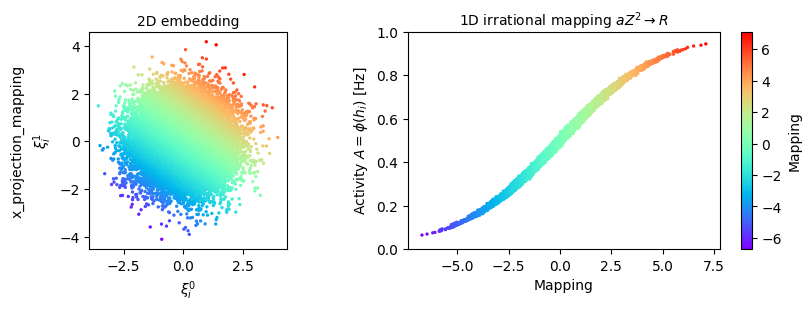

In [12]:
fig, axes = plt.subplots(constrained_layout=True, ncols=2, figsize=(4*2, 3))

plot_2D_to_1D_mapping(rnn, irrational_mapping(rnn.F), activity, figax=(fig, axes), cmap='rainbow', s=2)
axes[1].set_ylim((0, 1))

add_headers(fig, row_headers=[mapping_fn.__name__ for mapping_fn in mapping_fns])
add_headers(fig, col_headers=['2D embedding', '1D irrational mapping $aZ^2 \\rightarrow R$'])

plt.show()

## Mapping back to $\mathbb R^p$

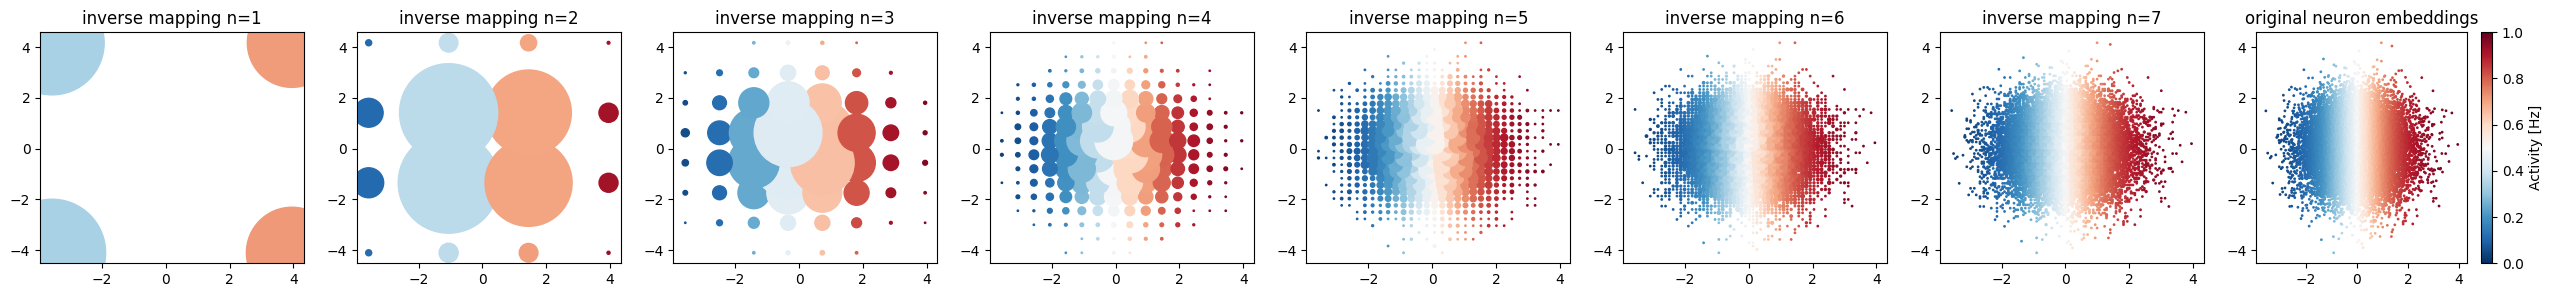

In [ ]:
rnn = LowRankRNN.new_valentin(p=2, N=20_000, phi=sigmoid, I_ext=zero, exclude_self_connections=True)

ns = [1,2,3,4,5,6,7]
fig, axes = plt.subplots(ncols=len(ns)+1, figsize=(4*(len(ns)+1), 3))
h0 = rnn.F[:, 0]

for n, ax in zip(ns, axes):
	mapping = RecursiveLocalMapping(nrec=n)
	indices = mapping.indices(rnn.F)
	idx_sort = np.argsort(indices)
	# coords = mapping.indices_to_coords(indices)
	# assert (coords == mapping.coords(rnn.F)).all()  # sanity check

	F_inverse = mapping.inverse_from_indices(indices, Box.new_bbox(rnn.F))
	F_inverse = F_inverse[idx_sort]  # sort in order of embedding
	_, idx_unique, idx_inverse, counts = np.unique(F_inverse, return_index=True, return_inverse=True, return_counts=True, axis=0)
	F_unique = F_inverse[np.sort(idx_unique)]  # we do this because we want the unique elements in order or apparition in the original array, not sorted by numpy
	counts = counts[idx_inverse[np.sort(idx_unique)]]

	# manually for sanity check
	# we do a binned statistic, but only on the bins that actually have neurons in them
	# instead, we can sort rnn.F given to binned statistic, and discard nan values
	# h0_binned = np.array([ h0[idx_sort][(F_unique[i] == F_inverse).all(axis=1)].mean() for i in range(len(F_unique)) ])
	
	h0_binned = mapping.binned_statistic(rnn.F[idx_sort], h0[idx_sort], fill_na=None)
	h0_binned = h0_binned[~np.isnan(h0_binned)]

	ax.scatter(F_unique[:, 0], F_unique[:, 1], c=rnn.phi(h0_binned), cmap='RdBu_r', s=counts, vmin=0, vmax=1)
	ax.set_title(f'inverse mapping {n=}')

sc = axes[-1].scatter(*rnn.F.T, s=1, c=rnn.phi(h0), cmap='RdBu_r', vmin=0, vmax=1)
axes[-1].set_title('original neuron embeddings')
fig.colorbar(sc, label='Activity [Hz]')

plt.show()